In [1]:
import numpy as np
import re
import string
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nltk
import json
from nltk import word_tokenize
from nltk.corpus import stopwords
from glob import glob
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import mutual_info_classif, f_classif, SelectKBest, chi2, SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

In [2]:
def flatten_dict(d, prefix=''):
    # TODO remove
    flat_d = {}
    for key in d:
        key_prefix = key if prefix == '' else f'{prefix}-{key}'
        if type(d[key]) == dict:
            flat_dkey = flatten_dict(d[key])
            flat_dkey = {f'{key_prefix}-{k}': v for k, v in flat_dkey.items()}
            flat_d.update(flat_dkey)
        else:
            flat_d[key_prefix] = d[key]
    return flat_d

In [3]:
docs = []
entries = ('url', 'images', 'top_img','MobileOptimized','site', 'keywords', 'canonical_link',
           'movies', 'source', 'summary', 'publish_date')
md_entries = {'robots','HandheldFriendly', 'viewport', 'emailvertical','Generator', 'article',
              'msapplication-TileColor', 'msapplication-TileImage', 'msapplication-square70x70logo'
              , 'msapplication-square150x150logo', 'msapplication-square310x310logo',
              'msapplication-wide310x150logo','msvalidate.01', 'fb','apple-mobile-web-app-capable',
             'MobileOptimized'}
og_entries = {'type', 'url', 'image', 'MobileOptimized'}
tw_entries = {'card','url', 'image', 'MobileOptimized'}

#Real News
for filename in glob('files/IR-FinalProject-DataSet/Real1/*.txt'):
    with open(filename) as file:
        data = file.read()
        # reconstructing the data as a dictionary
        f = json.loads(data)        
    
        
        for key in entries:
            if key in f:
                del f[key]
        for k in md_entries:
            if k in f['meta_data']:
                del f['meta_data'][k]
                
        for i, v in f.items():
            if i == 'og':
                for k in og_entries:
                    if k in f['og']:
                        del f['og'][k]
            if i == 'twitter':
                for k in tw_entries:
                    if k in f['twitter']:
                        del f['twitter'][k]
                                        
        for i in f['meta_data']:
            if i == 'og':
                for k in og_entries:
                    if k in f['meta_data']['og']:
                        del f['meta_data']['og'][k]
            if i == 'twitter':
                for k in tw_entries:
                    if k in f['meta_data']['twitter']:
                        del f['meta_data']['twitter'][k]
        
        f=flatten_dict(f)   
        docs.append(f)
print("size of real news collection: ", len(docs))
        

#Fake news
for filename in glob('files/IR-FinalProject-DataSet/Fake1/*.txt'):
    with open(filename) as file:
        data = file.read()
        # reconstructing the data as a dictionary
        f = json.loads(data)        

        
        for key in entries:
            if key in f:
                del f[key]
        for k in md_entries:
            if k in f['meta_data']:
                del f['meta_data'][k]
                
        for i, v in f.items():
            if i == 'og':
                for k in og_entries:
                    if k in f['og']:
                        del f['og'][k]
            if i == 'twitter':
                for k in tw_entries:
                    if k in f['twitter']:
                        del f['twitter'][k]
                              
        for i in f['meta_data']:
            if i == 'og':
                for k in og_entries:
                    if k in f['meta_data']['og']:
                        del f['meta_data']['og'][k]
            if i == 'twitter':
                for k in tw_entries:
                    if k in f['meta_data']['twitter']:
                        del f['meta_data']['twitter'][k]
        
        f=flatten_dict(f)   
        docs.append(f)

size of real news collection:  1003


In [4]:
newsd=pd.DataFrame(docs)

In [5]:
newsd.shape

(2004, 807)

In [6]:
newsd

,text,authors,title,meta_data-title,meta_data-og-site_name,meta_data-og-title,meta_data-og-description,meta_data-twitter-title,meta_data-twitter-description,meta_data-twitter-site-identifier,...,meta_data-GENERATOR,meta_data-snippet-image,meta_data-dateLastPubbed,meta_data-article.emb,meta_data-cx_pv_id,meta_data-pinterestapp-pinboard,meta_data-pinterestapp-source,meta_data-pinterestapp-repins,meta_data-og-width,meta_data-og-height
0,,[],You are being redirected...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Kate Pearson's journey is only just beginning ...,[Philiana Ng],"Chrissy Metz Talks Kate's Challenging, But 'Re...","Chrissy Metz Talks Kate's Challenging, But 'Re...",Entertainment Tonight,Chrissy Metz on Kate's 'Relatable''This Is Us'...,The 38-year-old actress opens up to ET about e...,Chrissy Metz on Kate's 'Relatable''This Is Us'...,The 38-year-old actress opens up to ET about e...,@etnow,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,51 Romantic Movies to Watch Because There's Ho...,[],Celebrity Weddings and Engagements,NaN,Brides,Celebrity Weddings and Engagements,All the latest celebrity wedding news–from J.L...,Celebrity Weddings and Engagements,All the latest celebrity wedding news–from J.L...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Character on American television series Scanda...,[],Quinn Perkins,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"From there, you transition to the leg press ma...","[Karina Hoshikawa, Molly Longman, Emily Ruane,...",I Tried Kim Kardashian's Butt Workout & Am For...,"Kim Kardashian Butt Exercises, Workout Routine...",NaN,I Tried Kim Kardashian's Butt Workout & Am For...,Kim K. shared her exact butt workout on her ap...,I Tried Kim Kardashian's Butt Workout & Am For...,Kim K. shared her exact butt workout on her ap...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999,"Kylie Jenner's pregnancy has ""helped her bond""...",[],Kylie Jenner's pregnancy brought her closer to...,NaN,NaN,Kylie Jenner's pregnancy brought her closer to...,Kylie Jenners pregnancy has helped her bond wi...,Kylie Jenner's pregnancy brought her closer to...,Kylie Jenners pregnancy has helped her bond wi...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000,President Donald Trump held a wide-ranging pre...,[Derek Lawrence],Celebrities react to President Trump's 'unhing...,NaN,EW.com,Celebrities React to President Trump's 'Unhing...,President Donald Trump held a wide-ranging pre...,Celebrities React to President Trump's 'Unhing...,"J.K. Rowling, Alec Baldwin, and more tweet the...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001,Kylie Jenner talked about why she enjoys chang...,[Lifestyle Reporter],New Mom Kylie Jenner Explains Why She Loves Ch...,NaN,HuffPost,New Mom Kylie Jenner Explains Why She Loves Ch...,"The 20-year-old also spoke about the ""baby blu...",New Mom Kylie Jenner Explains Why She Loves Ch...,"The 20-year-old also spoke about the ""baby blu...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002,Jen Threatens Justin: Stay Away From My Friend...,"[Radar Staff, May]",Jen Threatens Justin: Stay Away From My Friends!,NaN,RadarOnline,Jen Threatens Justin: Stay Away From My Friends!,RadarOnline.com learned exclusively Jennifer A...,Jen Threatens Justin: Stay Away From My Friends!,RadarOnline.com learned exclusively Jennifer A...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
texts = newsd['text'].tolist()
titles = newsd['title'].tolist()
mdtitle = newsd['meta_data-title'].tolist()
mdgtitle = newsd['meta_data-og-title'].tolist()
mdgdescription = newsd['meta_data-og-description'].tolist()
mdtwtitle = newsd['meta_data-twitter-title'].tolist()
mdtwdescription = newsd['meta_data-twitter-description'].tolist()
mdexpression = newsd['meta_data-expression'].tolist()
mdkeywords = newsd['meta_data-keywords'].tolist()
mdnewskeywords = newsd['meta_data-news_keywords'].tolist()
mddescription = newsd['meta_data-description'].tolist()

authors = newsd['authors'].tolist()

In [8]:
for i in range(len(texts)):
    texts[i]=str(texts[i]) + str(titles[i]) + str(mdtitle[i]) +str(mdgtitle[i])+ str(mdgdescription[i])+ str(mdtwtitle[i])+ str(mdtwdescription[i])+ str(mdexpression[i])+ str(mdkeywords[i])+ str(mdnewskeywords[i])+str(mddescription[i]) 

In [9]:
texts = list(filter(None, texts))

In [10]:
news = pd.DataFrame(texts, columns=['text'])
news['label'] = ""

In [53]:
for k, v in news.iterrows():
    #turning to lowercase
    v['text'] = v['text'].lower()
    # Remove unicode characters
    v['text'] = v['text'].encode('ascii', 'ignore').decode()
    stop_words = stopwords.words("english")
    v['text'] = ' '.join([word for word in v['text'].split(' ') if word not in (stop_words and {'that', 
                                                                                               'but', 'is', 'are', 'i'}) ])
    v['text'] = re.sub("https*\S+", " ", v['text'])
    v['text'] = re.sub("url", " ", v['text'])
    #Remove mentions
    v['text'] = re.sub("@\S+", " ", v['text'])
    # Remove Hashtags
    v['text'] = re.sub("#\S+", " ", v['text'])
    # Remove ticks and the next character
    v['text'] = re.sub("\'\w+", '', v['text'])
    # Remove punctuations
    v['text'] = re.sub('[%s]' % re.escape(string.punctuation), ' ', v['text'])
    # Remove numbers
    v['text'] = re.sub(r'\w*\d+\w*', '', v['text'])
    # Replace the over spaces
    v['text'] = re.sub('\s{2,}', " ", v['text'])

In [54]:
news

,text,label
0,redirected nannannannannannannannannan,1
1,kate pearson journey beginning us it roller co...,1
2,romantic movies watch there hope how lose guy...,1
3,character american television series scandal q...,1
4,there transition leg press machine instead pla...,1
...,...,...
1999,kylie jenner pregnancy helped bond kourtney ka...,0
2000,president donald trump held wide ranging press...,0
2001,kylie jenner talked enjoys changing diapers bo...,0
2002,jen threatens justin stay away friends theroux...,0


In [55]:
news['label'].iloc[:1002] = 1
news['label'].iloc[1002:] = 0

In [56]:
news

,text,label
0,redirected nannannannannannannannannan,1
1,kate pearson journey beginning us it roller co...,1
2,romantic movies watch there hope how lose guy...,1
3,character american television series scandal q...,1
4,there transition leg press machine instead pla...,1
...,...,...
1999,kylie jenner pregnancy helped bond kourtney ka...,0
2000,president donald trump held wide ranging press...,0
2001,kylie jenner talked enjoys changing diapers bo...,0
2002,jen threatens justin stay away friends theroux...,0


# Feature extraction methods

TF using tfidfVectorizer

In [18]:
vectorizer = TfidfVectorizer(use_idf=False, stop_words=stopwords.words('english'))
#     print(vectorizer.get_feature_names())
newsTF = vectorizer.fit_transform(news['text']) #.toarray()

In [14]:
news

,text,label
0,redirected nannannannannannannannannan,1
1,kate pearson journey beginning us it roller co...,1
2,romantic movies watch there hope how lose guy...,1
3,character american television series scandal q...,1
4,there transition leg press machine instead pla...,1
...,...,...
1999,kylie jenner pregnancy helped bond kourtney ka...,0
2000,president donald trump held wide ranging press...,0
2001,kylie jenner talked enjoys changing diapers bo...,0
2002,jen threatens justin stay away friends theroux...,0


TF using Countvectorizer

In [19]:
Cvectorizer = CountVectorizer(max_df=0.9, min_df=2, stop_words=stopwords.words('english'))
news_vec = Cvectorizer.fit_transform(news['text'])

TF-IDF using scikit learn same as: TF * IDF

In [20]:
vectorizer = TfidfVectorizer(max_df=0.9, min_df=2, use_idf=True, stop_words=stopwords.words('english'))
#     print(vectorizer.get_feature_names())
newsTFIDF = vectorizer.fit_transform(news['text']) #.toarray()

1 + log(TF)

In [21]:
vectorizer = TfidfVectorizer(max_df=0.9, min_df=2, use_idf=False, stop_words=stopwords.words('english'), sublinear_tf=True)
#     print(vectorizer.get_feature_names())
news1logTF = vectorizer.fit_transform(news['text']) #.toarray()

(1 + log(TF)) * IDF

In [22]:
vectorizer = TfidfVectorizer(max_df=0.9, min_df=2, use_idf=True, stop_words=stopwords.words('english'), sublinear_tf=True)
#     print(vectorizer.get_feature_names())
news1logTFIDF = vectorizer.fit_transform(news['text']) #.toarray()

# Feature selection methods

Mutual information

In [23]:
MI = pd.DataFrame(zip(vectorizer.get_feature_names(), 
                      mutual_info_classif(newsTFIDF, news['label'], discrete_features=True)), 
                  columns=['feature', 'score'])

F_classif

In [24]:
FC = pd.DataFrame(zip(Cvectorizer.get_feature_names(), f_classif(news_vec, news['label'])))

SelectKBest

In [25]:
# Select two features with highest chi-squared statistics
chi2_selector = SelectKBest(chi2, k=1000)
chi2_selector.fit(news_vec, news['label'])

# Look at scores returned from the selector for each feature
chi2_scores = pd.DataFrame(list(zip(Cvectorizer.get_feature_names(), chi2_selector.scores_, chi2_selector.pvalues_)), columns=['featur', 'score', 'pval'])
chi2_scores

# you can see that the kbest returned from SelectKBest 
#+ were the two features with the _highest_ score
kbest = np.asarray(Cvectorizer.get_feature_names())[chi2_selector.get_support()]

# Embedded Methods

SelectFromModel

In [26]:
SFM = SelectFromModel(estimator = LogisticRegression())
SFM_ft = SFM.fit_transform(newsTFIDF, news['label'])

/home/maedeh97/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [27]:
SFM.estimator_.coef_

array([[ 0.0504793 ,  0.02599231,  0.21025151, ..., -0.04651268,
        -0.03672543,  0.06583919]])

# Classification with hyper parameter tuning

In [34]:
results = []

feature_extractors = {'tf': news_vec, 'tfidf': newsTFIDF, '1logtf': news1logTF, '1logtfidf': news1logTFIDF}

feature_selectors = {'mi': mutual_info_classif, 'chi2': chi2, 'sfm': SelectFromModel،}

classifiers = {'random_forest': RandomForestClassifier,
               'logistic_regression':LogisticRegression, 'svm':  SVC, 'naive_bayes': GaussianNB}

for k1,fe in tqdm(feature_extractors.items()):
    
    for k2,fs in tqdm(feature_selectors.items()):
        
        for nFeat in tqdm([5, 20, 50, 100, 300, 500, 1000, 1500]):
            x_sel = SelectKBest(fs, k=nFeat).fit_transform(fe, news['label'])
            
            x_train, x_test, y_train, y_test = sk.model_selection.train_test_split(x_sel,news['label'],test_size=200)
            
            
            #scaling data
            sc = StandardScaler()
            x_train = sc.fit_transform(x_train.toarray())
            x_test = sc.transform(x_test.toarray())
            
            for k3, clf in classifiers.items():
                classifier = clf()
                param_grid = {}
                
                if k3 == 'random_forest':
                    # Number of trees in random forest
                    n_estimators = [200, 500, 1000]
                    # Number of features to consider at every split
                    # max_features = ['auto', 'sqrt']
                    # Maximum number of levels in tree
                    # max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
                    # max_depth.append(None)
                    # Minimum number of samples required to split a node
                    min_samples_split = [2, 5, 10]
                    # Minimum number of samples required at each leaf node
                    # min_samples_leaf = [1, 2, 4]
                    # Method of selecting samples for training each tree
                    # bootstrap = [True, False]
                    # Create the random grid

                    param_grid = {
                        'n_estimators': n_estimators,
                    #     'max_features': max_features,
                    #     'max_depth': max_depth,
                        'min_samples_split': min_samples_split,
                    #     'min_samples_leaf': min_samples_leaf,
                    #     'bootstrap': bootstrap
                    }
                    

                elif k3 == 'logistic_regression':

                    param_grid = {
                        'solver': ['newton-cg', 'lbfgs', 'liblinear'],
                        'penalty': ['l2'],
                        'C': [100, 10, 1.0, 0.1, 0.01],
                    }
                    
                elif k3 == 'svm':
                    param_grid = {'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ['rbf']}
                    
                elif k3 == 'naive bayes':
                    param_grid = {}
                model = GridSearchCV(classifier, param_grid = param_grid, cv=5, verbose=2, scoring= ['accuracy','f1', 'precision', 'recall'], n_jobs = -1, refit = 'f1')

                model.fit(x_train, y_train)
                print("fe, fs, nfeet, clf", k1, k2,nFeat, k3)
                print("model: ",model)
                print("best params: ", model.best_params_)
                

                result = {}
                result['feature_extractors'] = k1
                result['feature_selectors'] = k2
                result['nFeat'] = nFeat
                result['classifier'] = k3
                result['acc'] = model.cv_results_['mean_test_accuracy'][0]
                result['f1'] = model.cv_results_['mean_test_f1'][0]
                result['precision'] = model.cv_results_['mean_test_precision'][0]
                result['recall'] = model.cv_results_['mean_test_recall'][0]
                results.append(result)













  0%|          | 0/4 [00:00<?, ?it/s]












  0%|          | 0/2 [00:00<?, ?it/s]













  0%|          | 0/8 [00:00<?, ?it/s]

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   11.9s finished


fe, fs, nfeet, clf tf mi 5 random_forest
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


fe, fs, nfeet, clf tf mi 5 logistic_regression
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'], v

[Parallel(n_jobs=-1)]: Done  10 out of  25 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished














 12%|█▎        | 1/8 [00:35<04:10, 35.81s/it]

fe, fs, nfeet, clf tf mi 5 svm
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'], verbose=2)
best params:  {'C': 1, 'kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
fe, fs, nfeet, clf tf mi 5 naive_bayes
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GaussianNB(priors=None, var_smoothing=1e-09), iid='warn',
    

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   12.0s finished


fe, fs, nfeet, clf tf mi 20 random_forest
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                               

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


fe, fs, nfeet, clf tf mi 20 logistic_regression
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'], 

[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished














 25%|██▌       | 2/8 [01:09<03:31, 35.29s/it]

fe, fs, nfeet, clf tf mi 20 svm
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'], verbose=2)
best params:  {'C': 1, 'kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
fe, fs, nfeet, clf tf mi 20 naive_bayes
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GaussianNB(priors=None, var_smoothing=1e-09), iid='warn',
  

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   14.6s finished


fe, fs, nfeet, clf tf mi 50 random_forest
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                               

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  60 out of  75 | elapsed:    0.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


fe, fs, nfeet, clf tf mi 50 logistic_regression
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'], 

[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:    1.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished














 38%|███▊      | 3/8 [01:48<03:01, 36.34s/it]

fe, fs, nfeet, clf tf mi 50 svm
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'], verbose=2)
best params:  {'C': 1, 'kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
fe, fs, nfeet, clf tf mi 50 naive_bayes
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GaussianNB(priors=None, var_smoothing=1e-09), iid='warn',
  

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   17.3s finished


fe, fs, nfeet, clf tf mi 100 random_forest
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                              

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  60 out of  75 | elapsed:    2.0s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    2.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


fe, fs, nfeet, clf tf mi 100 logistic_regression
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'],

[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:    2.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    3.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished














 50%|█████     | 4/8 [02:30<02:31, 38.00s/it]

fe, fs, nfeet, clf tf mi 100 svm
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'], verbose=2)
best params:  {'C': 10, 'kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
fe, fs, nfeet, clf tf mi 100 naive_bayes
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GaussianNB(priors=None, var_smoothing=1e-09), iid='warn',

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   24.5s finished


fe, fs, nfeet, clf tf mi 300 random_forest
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                              

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    8.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


fe, fs, nfeet, clf tf mi 300 logistic_regression
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'],

[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:    9.2s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   10.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished














 62%|██████▎   | 5/8 [03:37<02:19, 46.62s/it]

fe, fs, nfeet, clf tf mi 300 svm
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'], verbose=2)
best params:  {'C': 1, 'kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
fe, fs, nfeet, clf tf mi 300 naive_bayes
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GaussianNB(priors=None, var_smoothing=1e-09), iid='warn',


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   31.7s finished


fe, fs, nfeet, clf tf mi 500 random_forest
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                              

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   12.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


fe, fs, nfeet, clf tf mi 500 logistic_regression
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'],

[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:   15.7s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   17.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished














 75%|███████▌  | 6/8 [05:04<01:57, 58.74s/it]

fe, fs, nfeet, clf tf mi 500 svm
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'], verbose=2)
best params:  {'C': 1, 'kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
fe, fs, nfeet, clf tf mi 500 naive_bayes
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GaussianNB(priors=None, var_smoothing=1e-09), iid='warn',


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   48.5s finished


fe, fs, nfeet, clf tf mi 1000 random_forest
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                             

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   18.2s finished


fe, fs, nfeet, clf tf mi 1000 logistic_regression
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall']

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:   28.9s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   32.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished














 88%|████████▊ | 7/8 [07:12<01:19, 79.60s/it]

fe, fs, nfeet, clf tf mi 1000 svm
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'], verbose=2)
best params:  {'C': 1, 'kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
fe, fs, nfeet, clf tf mi 1000 naive_bayes
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GaussianNB(priors=None, var_smoothing=1e-09), iid='warn'

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   57.7s finished


fe, fs, nfeet, clf tf mi 1500 random_forest
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                             

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   21.0s finished


fe, fs, nfeet, clf tf mi 1500 logistic_regression
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall']

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:   40.0s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   45.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
















fe, fs, nfeet, clf tf mi 1500 svm
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'], verbose=2)
best params:  {'C': 1, 'kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
fe, fs, nfeet, clf tf mi 1500 naive_bayes
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GaussianNB(priors=None, var_smoothing=1e-09), iid='warn'

100%|██████████| 8/8 [09:45<00:00, 73.22s/it] 













 50%|█████     | 1/2 [09:45<09:45, 585.79s/it]













  0%|          | 0/8 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    8.5s finished


fe, fs, nfeet, clf tf chi2 5 random_forest
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                              

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.2s finished


fe, fs, nfeet, clf tf chi2 5 logistic_regression
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'],

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  25 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished














 12%|█▎        | 1/8 [00:10<01:14, 10.69s/it]

fe, fs, nfeet, clf tf chi2 5 svm
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'], verbose=2)
best params:  {'C': 1, 'kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
fe, fs, nfeet, clf tf chi2 5 naive_bayes
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GaussianNB(priors=None, var_smoothing=1e-09), iid='warn',


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   10.5s finished


fe, fs, nfeet, clf tf chi2 20 random_forest
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                             

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


fe, fs, nfeet, clf tf chi2 20 logistic_regression
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall']

[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished














 25%|██▌       | 2/8 [00:24<01:08, 11.49s/it]

fe, fs, nfeet, clf tf chi2 20 svm
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'], verbose=2)
best params:  {'C': 1, 'kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
fe, fs, nfeet, clf tf chi2 20 naive_bayes
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GaussianNB(priors=None, var_smoothing=1e-09), iid='warn'

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   13.7s finished


fe, fs, nfeet, clf tf chi2 50 random_forest
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                             

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  60 out of  75 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


fe, fs, nfeet, clf tf chi2 50 logistic_regression
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall']

[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:    1.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished














 38%|███▊      | 3/8 [00:40<01:05, 13.01s/it]

fe, fs, nfeet, clf tf chi2 50 svm
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'], verbose=2)
best params:  {'C': 1, 'kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
fe, fs, nfeet, clf tf chi2 50 naive_bayes
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GaussianNB(priors=None, var_smoothing=1e-09), iid='warn'

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   16.6s finished


fe, fs, nfeet, clf tf chi2 100 random_forest
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                            

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  60 out of  75 | elapsed:    1.5s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


fe, fs, nfeet, clf tf chi2 100 logistic_regression
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'

[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:    2.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished














 50%|█████     | 4/8 [01:04<01:05, 16.28s/it]

fe, fs, nfeet, clf tf chi2 100 svm
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'], verbose=2)
best params:  {'C': 1, 'kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
fe, fs, nfeet, clf tf chi2 100 naive_bayes
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GaussianNB(priors=None, var_smoothing=1e-09), iid='war

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   21.4s finished


fe, fs, nfeet, clf tf chi2 300 random_forest
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                            

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    7.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


fe, fs, nfeet, clf tf chi2 300 logistic_regression
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'

[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:    7.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    8.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
/home/maedeh97/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)














 62%|██████▎   | 5/8 [01:44<01:09, 23.33s/it]

fe, fs, nfeet, clf tf chi2 300 svm
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'], verbose=2)
best params:  {'C': 1, 'kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
fe, fs, nfeet, clf tf chi2 300 naive_bayes
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GaussianNB(priors=None, var_smoothing=1e-09), iid='war

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   27.3s finished


fe, fs, nfeet, clf tf chi2 500 random_forest
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                            

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   11.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


fe, fs, nfeet, clf tf chi2 500 logistic_regression
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'

[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:   12.8s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   14.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
/home/maedeh97/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)














 75%|███████▌  | 6/8 [02:39<01:05, 32.92s/it]

fe, fs, nfeet, clf tf chi2 500 svm
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'], verbose=2)
best params:  {'C': 1, 'kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
fe, fs, nfeet, clf tf chi2 500 naive_bayes
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GaussianNB(priors=None, var_smoothing=1e-09), iid='war

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   41.6s finished


fe, fs, nfeet, clf tf chi2 1000 random_forest
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                           

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   15.8s finished


fe, fs, nfeet, clf tf chi2 1000 logistic_regression
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:   28.4s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   32.0s finished


fe, fs, nfeet, clf tf chi2 1000 svm
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'], verbose=2)
best params:  {'C': 1, 'kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished














 88%|████████▊ | 7/8 [04:19<00:52, 52.96s/it]

fe, fs, nfeet, clf tf chi2 1000 naive_bayes
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GaussianNB(priors=None, var_smoothing=1e-09), iid='warn',
             n_jobs=-1, param_grid={}, pre_dispatch='2*n_jobs', refit='f1',
             return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'], verbose=2)
best params:  {}
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   35.6s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.0min finished


fe, fs, nfeet, clf tf chi2 1500 random_forest
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                           

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   21.6s finished


fe, fs, nfeet, clf tf chi2 1500 logistic_regression
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:   45.9s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   51.9s finished
/home/maedeh97/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


fe, fs, nfeet, clf tf chi2 1500 svm
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'], verbose=2)
best params:  {'C': 1, 'kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished














100%|██████████| 8/8 [06:48<00:00, 51.05s/it]













100%|██████████| 2/2 [16:34<00:00, 497.09s/it]












 25%|██▌       | 1/4 [16:34<49:42, 994.19s/it]












  0%|          | 0/2 [00:00<?, ?it/s]













  0%|          | 0/8 [00:00<?, ?it/s]

fe, fs, nfeet, clf tf chi2 1500 naive_bayes
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GaussianNB(priors=None, var_smoothing=1e-09), iid='warn',
             n_jobs=-1, param_grid={}, pre_dispatch='2*n_jobs', refit='f1',
             return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'], verbose=2)
best params:  {}
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   14.6s finished


fe, fs, nfeet, clf tfidf mi 5 random_forest
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                             

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


fe, fs, nfeet, clf tfidf mi 5 logistic_regression
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall']

[Parallel(n_jobs=-1)]: Done  10 out of  25 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
/home/maedeh97/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)














 12%|█▎        | 1/8 [00:36<04:17, 36.72s/it]

fe, fs, nfeet, clf tfidf mi 5 svm
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'], verbose=2)
best params:  {'C': 10, 'kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
fe, fs, nfeet, clf tfidf mi 5 naive_bayes
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GaussianNB(priors=None, var_smoothing=1e-09), iid='warn

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   17.2s finished


fe, fs, nfeet, clf tfidf mi 20 random_forest
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                            

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


fe, fs, nfeet, clf tfidf mi 20 logistic_regression
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'

[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:    1.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished














 25%|██▌       | 2/8 [01:16<03:46, 37.70s/it]

fe, fs, nfeet, clf tfidf mi 20 svm
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'], verbose=2)
best params:  {'C': 1, 'kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
fe, fs, nfeet, clf tfidf mi 20 naive_bayes
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GaussianNB(priors=None, var_smoothing=1e-09), iid='war

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   19.2s finished


fe, fs, nfeet, clf tfidf mi 50 random_forest
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                            

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


fe, fs, nfeet, clf tfidf mi 50 logistic_regression
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'

[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:    1.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished














 38%|███▊      | 3/8 [01:58<03:14, 38.87s/it]

fe, fs, nfeet, clf tfidf mi 50 svm
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'], verbose=2)
best params:  {'C': 1, 'kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
fe, fs, nfeet, clf tfidf mi 50 naive_bayes
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GaussianNB(priors=None, var_smoothing=1e-09), iid='war

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   22.2s finished


fe, fs, nfeet, clf tfidf mi 100 random_forest
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                           

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


fe, fs, nfeet, clf tfidf mi 100 logistic_regression
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall

[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:    2.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished














 50%|█████     | 4/8 [02:43<02:42, 40.63s/it]

fe, fs, nfeet, clf tfidf mi 100 svm
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'], verbose=2)
best params:  {'C': 1, 'kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
fe, fs, nfeet, clf tfidf mi 100 naive_bayes
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GaussianNB(priors=None, var_smoothing=1e-09), iid='w

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   29.5s finished


fe, fs, nfeet, clf tfidf mi 300 random_forest
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                           

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    3.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


fe, fs, nfeet, clf tfidf mi 300 logistic_regression
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall

[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:    9.2s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   10.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished














 62%|██████▎   | 5/8 [03:47<02:23, 47.71s/it]

fe, fs, nfeet, clf tfidf mi 300 svm
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'], verbose=2)
best params:  {'C': 1, 'kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
fe, fs, nfeet, clf tfidf mi 300 naive_bayes
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GaussianNB(priors=None, var_smoothing=1e-09), iid='w

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   40.6s finished


fe, fs, nfeet, clf tfidf mi 500 random_forest
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                           

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   15.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


fe, fs, nfeet, clf tfidf mi 500 logistic_regression
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall

[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:   14.8s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   16.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished














 75%|███████▌  | 6/8 [05:28<02:07, 63.65s/it]

fe, fs, nfeet, clf tfidf mi 500 svm
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'], verbose=2)
best params:  {'C': 1, 'kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
fe, fs, nfeet, clf tfidf mi 500 naive_bayes
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GaussianNB(priors=None, var_smoothing=1e-09), iid='w

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   57.7s finished


fe, fs, nfeet, clf tfidf mi 1000 random_forest
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                          

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   16.8s finished


fe, fs, nfeet, clf tfidf mi 1000 logistic_regression
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recal

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:   53.1s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   59.3s finished
/home/maedeh97/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


fe, fs, nfeet, clf tfidf mi 1000 svm
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'], verbose=2)
best params:  {'C': 1, 'kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished














 88%|████████▊ | 7/8 [08:07<01:32, 92.40s/it]

fe, fs, nfeet, clf tfidf mi 1000 naive_bayes
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GaussianNB(priors=None, var_smoothing=1e-09), iid='warn',
             n_jobs=-1, param_grid={}, pre_dispatch='2*n_jobs', refit='f1',
             return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'], verbose=2)
best params:  {}
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  2.1min finished


fe, fs, nfeet, clf tfidf mi 1500 random_forest
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                          

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   16.4s finished


fe, fs, nfeet, clf tfidf mi 1500 logistic_regression
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recal

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:   45.5s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   51.9s finished


fe, fs, nfeet, clf tfidf mi 1500 svm
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'], verbose=2)
best params:  {'C': 1, 'kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished














100%|██████████| 8/8 [12:11<00:00, 91.42s/it] 













 50%|█████     | 1/2 [12:11<12:11, 731.39s/it]













  0%|          | 0/8 [00:00<?, ?it/s]

fe, fs, nfeet, clf tfidf mi 1500 naive_bayes
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GaussianNB(priors=None, var_smoothing=1e-09), iid='warn',
             n_jobs=-1, param_grid={}, pre_dispatch='2*n_jobs', refit='f1',
             return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'], verbose=2)
best params:  {}
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    9.1s finished


fe, fs, nfeet, clf tfidf chi2 5 random_forest
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                           

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


fe, fs, nfeet, clf tfidf chi2 5 logistic_regression
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall

[Parallel(n_jobs=-1)]: Done  10 out of  25 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished














 12%|█▎        | 1/8 [00:10<01:12, 10.32s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


fe, fs, nfeet, clf tfidf chi2 5 svm
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'], verbose=2)
best params:  {'C': 10, 'kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
fe, fs, nfeet, clf tfidf chi2 5 naive_bayes
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GaussianNB(priors=None, var_smoothing=1e-09), iid='

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   12.1s finished


fe, fs, nfeet, clf tfidf chi2 20 random_forest
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                          

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


fe, fs, nfeet, clf tfidf chi2 20 logistic_regression
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recal

[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished














 25%|██▌       | 2/8 [00:25<01:10, 11.80s/it]

fe, fs, nfeet, clf tfidf chi2 20 svm
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'], verbose=2)
best params:  {'C': 1, 'kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
fe, fs, nfeet, clf tfidf chi2 20 naive_bayes
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GaussianNB(priors=None, var_smoothing=1e-09), iid=

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   16.0s finished


fe, fs, nfeet, clf tfidf chi2 50 random_forest
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                          

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  60 out of  75 | elapsed:    0.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


fe, fs, nfeet, clf tfidf chi2 50 logistic_regression
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recal

[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:    1.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished














 38%|███▊      | 3/8 [00:44<01:09, 13.99s/it]

fe, fs, nfeet, clf tfidf chi2 50 svm
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'], verbose=2)
best params:  {'C': 1, 'kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
fe, fs, nfeet, clf tfidf chi2 50 naive_bayes
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GaussianNB(priors=None, var_smoothing=1e-09), iid=

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   18.9s finished


fe, fs, nfeet, clf tfidf chi2 100 random_forest
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                         

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  60 out of  75 | elapsed:    1.8s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


fe, fs, nfeet, clf tfidf chi2 100 logistic_regression
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'reca

[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:    2.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished














 50%|█████     | 4/8 [01:10<01:09, 17.44s/it]

fe, fs, nfeet, clf tfidf chi2 100 svm
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'], verbose=2)
best params:  {'C': 1, 'kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
fe, fs, nfeet, clf tfidf chi2 100 naive_bayes
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GaussianNB(priors=None, var_smoothing=1e-09), ii

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   25.4s finished


fe, fs, nfeet, clf tfidf chi2 300 random_forest
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                         

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    7.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


fe, fs, nfeet, clf tfidf chi2 300 logistic_regression
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'reca

[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:    8.0s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    8.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished














 62%|██████▎   | 5/8 [01:53<01:15, 25.17s/it]

fe, fs, nfeet, clf tfidf chi2 300 svm
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'], verbose=2)
best params:  {'C': 1, 'kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
fe, fs, nfeet, clf tfidf chi2 300 naive_bayes
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GaussianNB(priors=None, var_smoothing=1e-09), ii

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   33.4s finished


fe, fs, nfeet, clf tfidf chi2 500 random_forest
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                         

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   14.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


fe, fs, nfeet, clf tfidf chi2 500 logistic_regression
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'reca

[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:   16.2s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   18.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished














 75%|███████▌  | 6/8 [03:04<01:17, 38.90s/it]

fe, fs, nfeet, clf tfidf chi2 500 svm
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'], verbose=2)
best params:  {'C': 1, 'kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
fe, fs, nfeet, clf tfidf chi2 500 naive_bayes
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GaussianNB(priors=None, var_smoothing=1e-09), ii

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   53.5s finished


fe, fs, nfeet, clf tfidf chi2 1000 random_forest
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                        

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   15.1s finished


fe, fs, nfeet, clf tfidf chi2 1000 logistic_regression
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'rec

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:   28.8s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   32.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished














 88%|████████▊ | 7/8 [04:52<00:59, 59.70s/it]

fe, fs, nfeet, clf tfidf chi2 1000 svm
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'], verbose=2)
best params:  {'C': 1, 'kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
fe, fs, nfeet, clf tfidf chi2 1000 naive_bayes
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GaussianNB(priors=None, var_smoothing=1e-09), 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.0min finished


fe, fs, nfeet, clf tfidf chi2 1500 random_forest
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                        

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   14.6s finished


fe, fs, nfeet, clf tfidf chi2 1500 logistic_regression
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'rec

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:   40.4s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   46.2s finished
/home/maedeh97/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


fe, fs, nfeet, clf tfidf chi2 1500 svm
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'], verbose=2)
best params:  {'C': 1, 'kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished














100%|██████████| 8/8 [07:07<00:00, 53.38s/it]













100%|██████████| 2/2 [19:18<00:00, 579.24s/it]












 50%|█████     | 2/4 [35:52<34:46, 1043.48s/it]












  0%|          | 0/2 [00:00<?, ?it/s]













  0%|          | 0/8 [00:00<?, ?it/s]

fe, fs, nfeet, clf tfidf chi2 1500 naive_bayes
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GaussianNB(priors=None, var_smoothing=1e-09), iid='warn',
             n_jobs=-1, param_grid={}, pre_dispatch='2*n_jobs', refit='f1',
             return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'], verbose=2)
best params:  {}
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   13.7s finished


fe, fs, nfeet, clf 1logtf mi 5 random_forest
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                            

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.2s finished


fe, fs, nfeet, clf 1logtf mi 5 logistic_regression
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished














 12%|█▎        | 1/8 [00:33<03:52, 33.27s/it]

fe, fs, nfeet, clf 1logtf mi 5 svm
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'], verbose=2)
best params:  {'C': 0.1, 'kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
fe, fs, nfeet, clf 1logtf mi 5 naive_bayes
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GaussianNB(priors=None, var_smoothing=1e-09), iid='w

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   15.6s finished


fe, fs, nfeet, clf 1logtf mi 20 random_forest
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                           

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.2s finished


fe, fs, nfeet, clf 1logtf mi 20 logistic_regression
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:    1.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished














 25%|██▌       | 2/8 [01:07<03:20, 33.44s/it]

fe, fs, nfeet, clf 1logtf mi 20 svm
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'], verbose=2)
best params:  {'C': 0.001, 'kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
fe, fs, nfeet, clf 1logtf mi 20 naive_bayes
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GaussianNB(priors=None, var_smoothing=1e-09), ii

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   19.1s finished


fe, fs, nfeet, clf 1logtf mi 50 random_forest
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                           

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


fe, fs, nfeet, clf 1logtf mi 50 logistic_regression
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall

[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:    1.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished














 38%|███▊      | 3/8 [01:48<02:58, 35.73s/it]

fe, fs, nfeet, clf 1logtf mi 50 svm
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'], verbose=2)
best params:  {'C': 1, 'kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
fe, fs, nfeet, clf 1logtf mi 50 naive_bayes
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GaussianNB(priors=None, var_smoothing=1e-09), iid='w

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   21.8s finished


fe, fs, nfeet, clf 1logtf mi 100 random_forest
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                          

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 out of  75 | elapsed:    0.4s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


fe, fs, nfeet, clf 1logtf mi 100 logistic_regression
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recal

[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:    2.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished














 50%|█████     | 4/8 [02:32<02:33, 38.31s/it]

fe, fs, nfeet, clf 1logtf mi 100 svm
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'], verbose=2)
best params:  {'C': 0.1, 'kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
fe, fs, nfeet, clf 1logtf mi 100 naive_bayes
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GaussianNB(priors=None, var_smoothing=1e-09), ii

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   29.4s finished


fe, fs, nfeet, clf 1logtf mi 300 random_forest
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                          

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  60 out of  75 | elapsed:    2.1s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    2.3s finished


fe, fs, nfeet, clf 1logtf mi 300 logistic_regression
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recal

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:    8.4s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    9.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished














 62%|██████▎   | 5/8 [03:36<02:18, 46.09s/it]

fe, fs, nfeet, clf 1logtf mi 300 svm
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'], verbose=2)
best params:  {'C': 0.001, 'kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
fe, fs, nfeet, clf 1logtf mi 300 naive_bayes
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GaussianNB(priors=None, var_smoothing=1e-09), 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   35.0s finished


fe, fs, nfeet, clf 1logtf mi 500 random_forest
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                          

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   11.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


fe, fs, nfeet, clf 1logtf mi 500 logistic_regression
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recal

[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:   13.8s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   15.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished














 75%|███████▌  | 6/8 [05:00<01:54, 57.25s/it]

fe, fs, nfeet, clf 1logtf mi 500 svm
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'], verbose=2)
best params:  {'C': 1, 'kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
fe, fs, nfeet, clf 1logtf mi 500 naive_bayes
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GaussianNB(priors=None, var_smoothing=1e-09), iid=

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   50.2s finished


fe, fs, nfeet, clf 1logtf mi 1000 random_forest
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                         

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   11.5s finished


fe, fs, nfeet, clf 1logtf mi 1000 logistic_regression
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'reca

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:   27.7s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   32.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished














 88%|████████▊ | 7/8 [07:02<01:16, 76.72s/it]

fe, fs, nfeet, clf 1logtf mi 1000 svm
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'], verbose=2)
best params:  {'C': 1, 'kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
fe, fs, nfeet, clf 1logtf mi 1000 naive_bayes
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GaussianNB(priors=None, var_smoothing=1e-09), ii

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.1min finished


fe, fs, nfeet, clf 1logtf mi 1500 random_forest
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                         

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   15.3s finished


fe, fs, nfeet, clf 1logtf mi 1500 logistic_regression
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'reca

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:   41.3s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   48.2s finished


fe, fs, nfeet, clf 1logtf mi 1500 svm
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'], verbose=2)
best params:  {'C': 1, 'kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished














100%|██████████| 8/8 [09:37<00:00, 72.15s/it] 













 50%|█████     | 1/2 [09:37<09:37, 577.19s/it]













  0%|          | 0/8 [00:00<?, ?it/s]

fe, fs, nfeet, clf 1logtf mi 1500 naive_bayes
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GaussianNB(priors=None, var_smoothing=1e-09), iid='warn',
             n_jobs=-1, param_grid={}, pre_dispatch='2*n_jobs', refit='f1',
             return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'], verbose=2)
best params:  {}
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    9.3s finished


fe, fs, nfeet, clf 1logtf chi2 5 random_forest
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                          

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


fe, fs, nfeet, clf 1logtf chi2 5 logistic_regression
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recal

[Parallel(n_jobs=-1)]: Done  10 out of  25 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished














 12%|█▎        | 1/8 [00:10<01:12, 10.41s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


fe, fs, nfeet, clf 1logtf chi2 5 svm
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'], verbose=2)
best params:  {'C': 0.1, 'kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
fe, fs, nfeet, clf 1logtf chi2 5 naive_bayes
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GaussianNB(priors=None, var_smoothing=1e-09), ii

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   11.9s finished


fe, fs, nfeet, clf 1logtf chi2 20 random_forest
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                         

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


fe, fs, nfeet, clf 1logtf chi2 20 logistic_regression
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'reca

[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished














 25%|██▌       | 2/8 [00:24<01:08, 11.50s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


fe, fs, nfeet, clf 1logtf chi2 20 svm
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'], verbose=2)
best params:  {'C': 1, 'kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
fe, fs, nfeet, clf 1logtf chi2 20 naive_bayes
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GaussianNB(priors=None, var_smoothing=1e-09), ii

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   14.7s finished


fe, fs, nfeet, clf 1logtf chi2 50 random_forest
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                         

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  60 out of  75 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


fe, fs, nfeet, clf 1logtf chi2 50 logistic_regression
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'reca

[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:    1.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished














 38%|███▊      | 3/8 [00:43<01:09, 13.82s/it]

fe, fs, nfeet, clf 1logtf chi2 50 svm
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'], verbose=2)
best params:  {'C': 1, 'kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
fe, fs, nfeet, clf 1logtf chi2 50 naive_bayes
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GaussianNB(priors=None, var_smoothing=1e-09), ii

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   17.5s finished


fe, fs, nfeet, clf 1logtf chi2 100 random_forest
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                        

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  60 out of  75 | elapsed:    1.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


fe, fs, nfeet, clf 1logtf chi2 100 logistic_regression
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'rec

[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:    2.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished














 50%|█████     | 4/8 [01:06<01:05, 16.48s/it]

fe, fs, nfeet, clf 1logtf chi2 100 svm
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'], verbose=2)
best params:  {'C': 1, 'kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
fe, fs, nfeet, clf 1logtf chi2 100 naive_bayes
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GaussianNB(priors=None, var_smoothing=1e-09), 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   23.6s finished


fe, fs, nfeet, clf 1logtf chi2 300 random_forest
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                        

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    6.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


fe, fs, nfeet, clf 1logtf chi2 300 logistic_regression
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'rec

[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:    7.8s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    8.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished














 62%|██████▎   | 5/8 [01:49<01:13, 24.49s/it]

fe, fs, nfeet, clf 1logtf chi2 300 svm
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'], verbose=2)
best params:  {'C': 1, 'kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
fe, fs, nfeet, clf 1logtf chi2 300 naive_bayes
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GaussianNB(priors=None, var_smoothing=1e-09), 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   29.4s finished


fe, fs, nfeet, clf 1logtf chi2 500 random_forest
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                        

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    9.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


fe, fs, nfeet, clf 1logtf chi2 500 logistic_regression
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'rec

[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:   13.2s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   14.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished














 75%|███████▌  | 6/8 [02:49<01:10, 35.08s/it]

fe, fs, nfeet, clf 1logtf chi2 500 svm
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'], verbose=2)
best params:  {'C': 1, 'kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
fe, fs, nfeet, clf 1logtf chi2 500 naive_bayes
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GaussianNB(priors=None, var_smoothing=1e-09), 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   44.9s finished


fe, fs, nfeet, clf 1logtf chi2 1000 random_forest
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                       

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   10.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


fe, fs, nfeet, clf 1logtf chi2 1000 logistic_regression
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 're

[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:   27.0s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   30.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished














 88%|████████▊ | 7/8 [04:25<00:53, 53.54s/it]

fe, fs, nfeet, clf 1logtf chi2 1000 svm
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'], verbose=2)
best params:  {'C': 1, 'kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
fe, fs, nfeet, clf 1logtf chi2 1000 naive_bayes
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GaussianNB(priors=None, var_smoothing=1e-09)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   59.9s finished


fe, fs, nfeet, clf 1logtf chi2 1500 random_forest
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                       

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   13.7s finished


fe, fs, nfeet, clf 1logtf chi2 1500 logistic_regression
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 're

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:   40.8s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   46.9s finished
/home/maedeh97/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
















fe, fs, nfeet, clf 1logtf chi2 1500 svm
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'], verbose=2)
best params:  {'C': 1, 'kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
fe, fs, nfeet, clf 1logtf chi2 1500 naive_bayes
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GaussianNB(priors=None, var_smoothing=1e-09)

100%|██████████| 8/8 [06:40<00:00, 50.04s/it]













100%|██████████| 2/2 [16:17<00:00, 488.74s/it]












 75%|███████▌  | 3/4 [52:10<17:03, 1023.68s/it]












  0%|          | 0/2 [00:00<?, ?it/s]













  0%|          | 0/8 [00:00<?, ?it/s]

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   13.7s finished


fe, fs, nfeet, clf 1logtfidf mi 5 random_forest
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                         

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  25 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished














 12%|█▎        | 1/8 [00:31<03:41, 31.58s/it]

fe, fs, nfeet, clf 1logtfidf mi 5 svm
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'], verbose=2)
best params:  {'C': 1, 'kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
fe, fs, nfeet, clf 1logtfidf mi 5 naive_bayes
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GaussianNB(priors=None, var_smoothing=1e-09), ii

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   15.9s finished


fe, fs, nfeet, clf 1logtfidf mi 20 random_forest
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                        

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.2s finished


fe, fs, nfeet, clf 1logtfidf mi 20 logistic_regression
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'rec

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:    1.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished














 25%|██▌       | 2/8 [01:06<03:15, 32.60s/it]

fe, fs, nfeet, clf 1logtfidf mi 20 svm
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'], verbose=2)
best params:  {'C': 1, 'kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
fe, fs, nfeet, clf 1logtfidf mi 20 naive_bayes
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GaussianNB(priors=None, var_smoothing=1e-09), 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   18.9s finished


fe, fs, nfeet, clf 1logtfidf mi 50 random_forest
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                        

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


fe, fs, nfeet, clf 1logtfidf mi 50 logistic_regression
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'rec

[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:    1.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished














 38%|███▊      | 3/8 [01:47<02:55, 35.19s/it]

fe, fs, nfeet, clf 1logtfidf mi 50 svm
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'], verbose=2)
best params:  {'C': 1, 'kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
fe, fs, nfeet, clf 1logtfidf mi 50 naive_bayes
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GaussianNB(priors=None, var_smoothing=1e-09), 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   22.4s finished


fe, fs, nfeet, clf 1logtfidf mi 100 random_forest
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                       

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


fe, fs, nfeet, clf 1logtfidf mi 100 logistic_regression
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 're

[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:    2.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished














 50%|█████     | 4/8 [02:34<02:35, 38.78s/it]

fe, fs, nfeet, clf 1logtfidf mi 100 svm
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'], verbose=2)
best params:  {'C': 1, 'kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
fe, fs, nfeet, clf 1logtfidf mi 100 naive_bayes
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GaussianNB(priors=None, var_smoothing=1e-09)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   29.8s finished


fe, fs, nfeet, clf 1logtfidf mi 300 random_forest
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                       

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  60 out of  75 | elapsed:    2.1s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


fe, fs, nfeet, clf 1logtfidf mi 300 logistic_regression
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 're

[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:    8.2s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    9.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished














 62%|██████▎   | 5/8 [03:36<02:16, 45.60s/it]

fe, fs, nfeet, clf 1logtfidf mi 300 svm
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'], verbose=2)
best params:  {'C': 1, 'kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
fe, fs, nfeet, clf 1logtfidf mi 300 naive_bayes
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GaussianNB(priors=None, var_smoothing=1e-09)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   35.6s finished


fe, fs, nfeet, clf 1logtfidf mi 500 random_forest
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                       

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   10.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


fe, fs, nfeet, clf 1logtfidf mi 500 logistic_regression
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 're

[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:   13.7s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   15.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished














 75%|███████▌  | 6/8 [05:03<01:55, 57.98s/it]

fe, fs, nfeet, clf 1logtfidf mi 500 svm
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'], verbose=2)
best params:  {'C': 1, 'kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
fe, fs, nfeet, clf 1logtfidf mi 500 naive_bayes
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GaussianNB(priors=None, var_smoothing=1e-09)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   50.9s finished


fe, fs, nfeet, clf 1logtfidf mi 1000 random_forest
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                      

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   11.3s finished


fe, fs, nfeet, clf 1logtfidf mi 1000 logistic_regression
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'r

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:   27.6s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   32.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished














 88%|████████▊ | 7/8 [07:02<01:16, 76.34s/it]

fe, fs, nfeet, clf 1logtfidf mi 1000 svm
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'], verbose=2)
best params:  {'C': 1, 'kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
fe, fs, nfeet, clf 1logtfidf mi 1000 naive_bayes
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GaussianNB(priors=None, var_smoothing=1e-0

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.1min finished


fe, fs, nfeet, clf 1logtfidf mi 1500 random_forest
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                      

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   16.7s finished


fe, fs, nfeet, clf 1logtfidf mi 1500 logistic_regression
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'r

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:   44.1s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   50.7s finished
/home/maedeh97/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


fe, fs, nfeet, clf 1logtfidf mi 1500 svm
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'], verbose=2)
best params:  {'C': 1, 'kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished














100%|██████████| 8/8 [09:50<00:00, 73.78s/it] 













 50%|█████     | 1/2 [09:50<09:50, 590.23s/it]













  0%|          | 0/8 [00:00<?, ?it/s]

fe, fs, nfeet, clf 1logtfidf mi 1500 naive_bayes
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GaussianNB(priors=None, var_smoothing=1e-09), iid='warn',
             n_jobs=-1, param_grid={}, pre_dispatch='2*n_jobs', refit='f1',
             return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'], verbose=2)
best params:  {}
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    9.5s finished


fe, fs, nfeet, clf 1logtfidf chi2 5 random_forest
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                       

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


fe, fs, nfeet, clf 1logtfidf chi2 5 logistic_regression
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 're

[Parallel(n_jobs=-1)]: Done  10 out of  25 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished














 12%|█▎        | 1/8 [00:10<01:14, 10.65s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


fe, fs, nfeet, clf 1logtfidf chi2 5 svm
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'], verbose=2)
best params:  {'C': 0.1, 'kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
fe, fs, nfeet, clf 1logtfidf chi2 5 naive_bayes
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GaussianNB(priors=None, var_smoothing=1e-0

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   12.0s finished


fe, fs, nfeet, clf 1logtfidf chi2 20 random_forest
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                      

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


fe, fs, nfeet, clf 1logtfidf chi2 20 logistic_regression
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'r

[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished














 25%|██▌       | 2/8 [00:24<01:10, 11.68s/it]

fe, fs, nfeet, clf 1logtfidf chi2 20 svm
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'], verbose=2)
best params:  {'C': 1, 'kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
fe, fs, nfeet, clf 1logtfidf chi2 20 naive_bayes
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GaussianNB(priors=None, var_smoothing=1e-0

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   15.1s finished


fe, fs, nfeet, clf 1logtfidf chi2 50 random_forest
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                      

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  60 out of  75 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


fe, fs, nfeet, clf 1logtfidf chi2 50 logistic_regression
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'r

[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:    1.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished














 38%|███▊      | 3/8 [00:42<01:07, 13.55s/it]

fe, fs, nfeet, clf 1logtfidf chi2 50 svm
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'], verbose=2)
best params:  {'C': 1, 'kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
fe, fs, nfeet, clf 1logtfidf chi2 50 naive_bayes
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GaussianNB(priors=None, var_smoothing=1e-0

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   17.7s finished


fe, fs, nfeet, clf 1logtfidf chi2 100 random_forest
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                     

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  60 out of  75 | elapsed:    1.6s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


fe, fs, nfeet, clf 1logtfidf chi2 100 logistic_regression
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', '

[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:    2.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished














 50%|█████     | 4/8 [01:08<01:08, 17.11s/it]

fe, fs, nfeet, clf 1logtfidf chi2 100 svm
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'], verbose=2)
best params:  {'C': 1, 'kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
fe, fs, nfeet, clf 1logtfidf chi2 100 naive_bayes
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GaussianNB(priors=None, var_smoothing=1e

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   24.3s finished


fe, fs, nfeet, clf 1logtfidf chi2 300 random_forest
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                     

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    6.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


fe, fs, nfeet, clf 1logtfidf chi2 300 logistic_regression
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', '

[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:    8.1s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    9.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished














 62%|██████▎   | 5/8 [01:50<01:14, 24.77s/it]

fe, fs, nfeet, clf 1logtfidf chi2 300 svm
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'], verbose=2)
best params:  {'C': 1, 'kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
fe, fs, nfeet, clf 1logtfidf chi2 300 naive_bayes
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GaussianNB(priors=None, var_smoothing=1e

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   31.0s finished


fe, fs, nfeet, clf 1logtfidf chi2 500 random_forest
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                     

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   10.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


fe, fs, nfeet, clf 1logtfidf chi2 500 logistic_regression
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', '

[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:   13.7s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   15.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished














 75%|███████▌  | 6/8 [02:52<01:11, 35.77s/it]

fe, fs, nfeet, clf 1logtfidf chi2 500 svm
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'], verbose=2)
best params:  {'C': 1, 'kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
fe, fs, nfeet, clf 1logtfidf chi2 500 naive_bayes
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GaussianNB(priors=None, var_smoothing=1e

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   48.7s finished


fe, fs, nfeet, clf 1logtfidf chi2 1000 random_forest
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                    

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   11.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


fe, fs, nfeet, clf 1logtfidf chi2 1000 logistic_regression
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 

[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:   28.6s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   32.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished














 88%|████████▊ | 7/8 [04:31<00:54, 54.75s/it]

fe, fs, nfeet, clf 1logtfidf chi2 1000 svm
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'], verbose=2)
best params:  {'C': 1, 'kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
fe, fs, nfeet, clf 1logtfidf chi2 1000 naive_bayes
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GaussianNB(priors=None, var_smoothing=

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.1min finished


fe, fs, nfeet, clf 1logtfidf chi2 1500 random_forest
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                    

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   14.4s finished


fe, fs, nfeet, clf 1logtfidf chi2 1500 logistic_regression
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:   43.1s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   49.6s finished
/home/maedeh97/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


fe, fs, nfeet, clf 1logtfidf chi2 1500 svm
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'], verbose=2)
best params:  {'C': 1, 'kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished














100%|██████████| 8/8 [06:54<00:00, 51.83s/it]













100%|██████████| 2/2 [16:44<00:00, 502.45s/it]












100%|██████████| 4/4 [1:08:55<00:00, 1033.77s/it]

fe, fs, nfeet, clf 1logtfidf chi2 1500 naive_bayes
model:  GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GaussianNB(priors=None, var_smoothing=1e-09), iid='warn',
             n_jobs=-1, param_grid={}, pre_dispatch='2*n_jobs', refit='f1',
             return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'], verbose=2)
best params:  {}


In [66]:
df = pd.DataFrame(results)
df

,feature_extractors,feature_selectors,nFeat,classifier,acc,f1,precision,recall
0,tf,mi,5,random_forest,0.694013,0.740804,0.646753,0.867977
1,tf,mi,5,logistic_regression,0.681818,0.738162,0.630538,0.891073
2,tf,mi,5,svm,0.503880,0.670107,0.503880,1.000000
3,tf,mi,5,naive_bayes,0.633592,0.724386,0.583216,0.955983
4,tf,mi,20,random_forest,0.717849,0.746085,0.674591,0.834825
...,...,...,...,...,...,...,...,...
251,1logtfidf,chi2,1000,naive_bayes,0.858647,0.860712,0.846071,0.876527
252,1logtfidf,chi2,1500,random_forest,0.796009,0.798708,0.788923,0.809729
253,1logtfidf,chi2,1500,logistic_regression,0.798780,0.793934,0.813844,0.775468
254,1logtfidf,chi2,1500,svm,0.501109,0.667651,0.501109,1.000000


accuracy

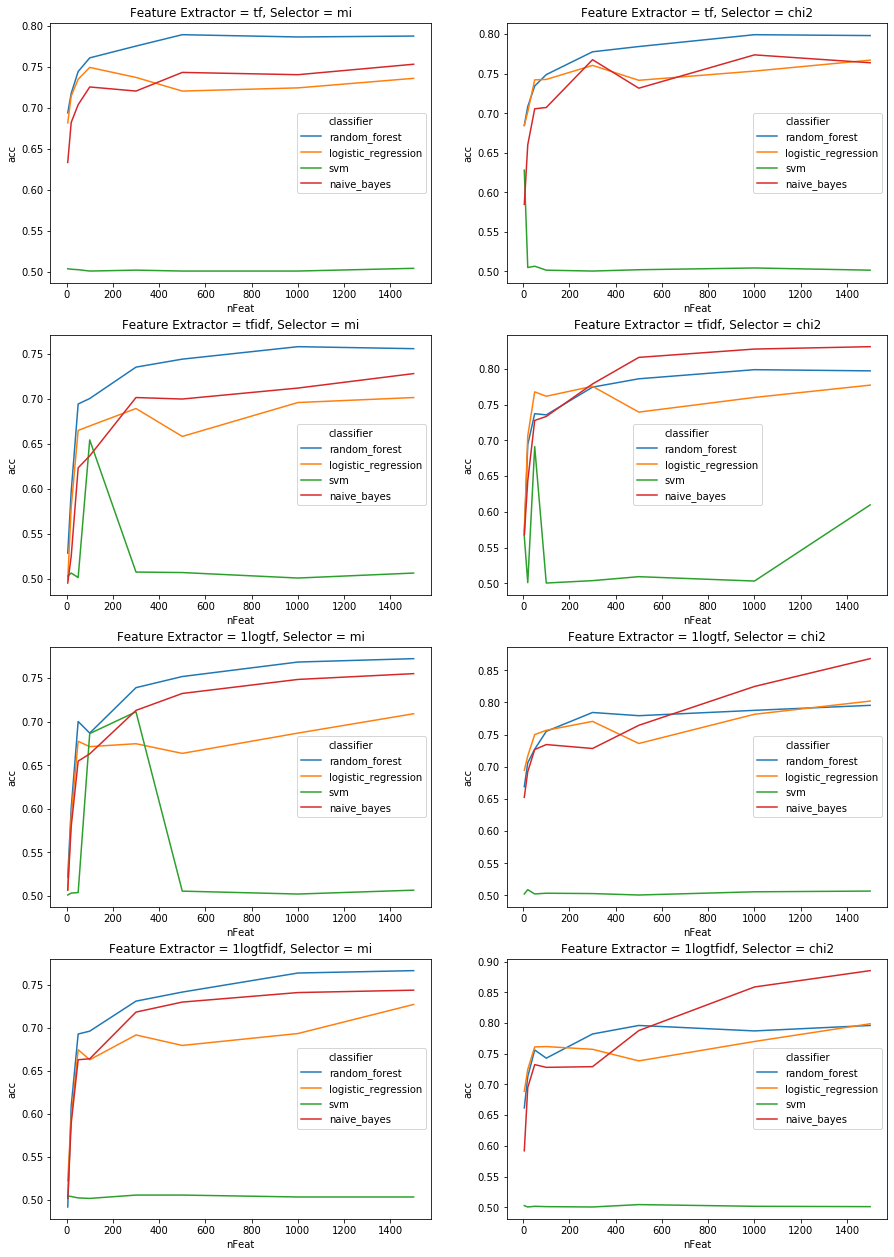

In [81]:
plt.figure(figsize=(15, 22))

i=1
for k1,fe in feature_extractors.items():
    for k2,fs in feature_selectors.items():
        plt.subplot(4, 2, i)
        i+=1
        df_cur = df[(df['feature_extractors'] == k1) & (df['feature_selectors'] == k2)]
        sns.lineplot('nFeat', 'acc', data=df_cur, hue='classifier')
        plt.title(f'Feature Extractor = {k1}, Selector = {k2}')

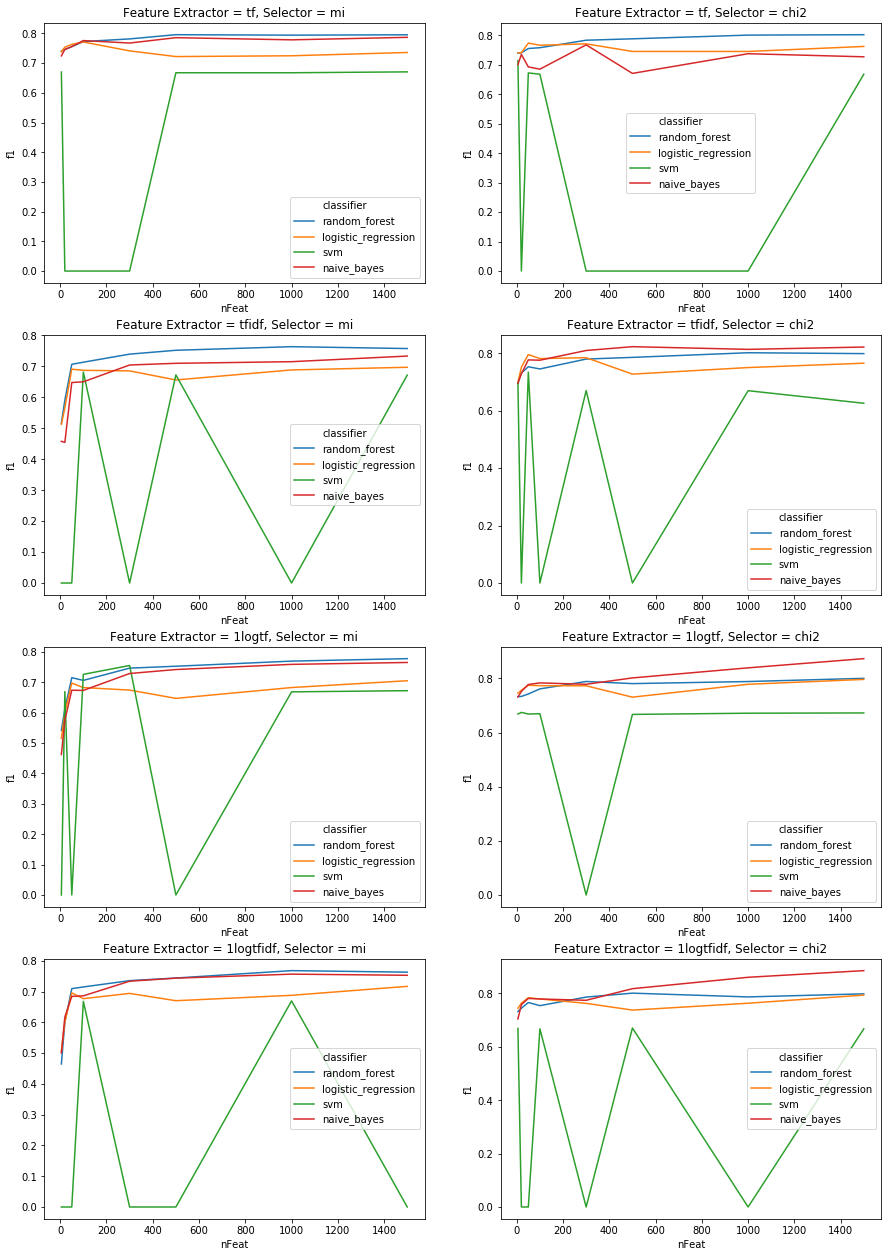

In [36]:
plt.figure(figsize=(15, 22))

i=1
for k1,fe in feature_extractors.items():
    for k2,fs in feature_selectors.items():
        plt.subplot(4, 2, i)
        i+=1
        df_cur = df[(df['feature_extractors'] == k1) & (df['feature_selectors'] == k2)]
        sns.lineplot('nFeat', 'f1', data=df_cur, hue='classifier')
        plt.title(f'Feature Extractor = {k1}, Selector = {k2}')

In [38]:
# df[['acc', 'f1', 'precision', 'recall']] = df[['acc', 'f1', 'precision', 'recall']].applymap(lambda x: x[0])

f1score

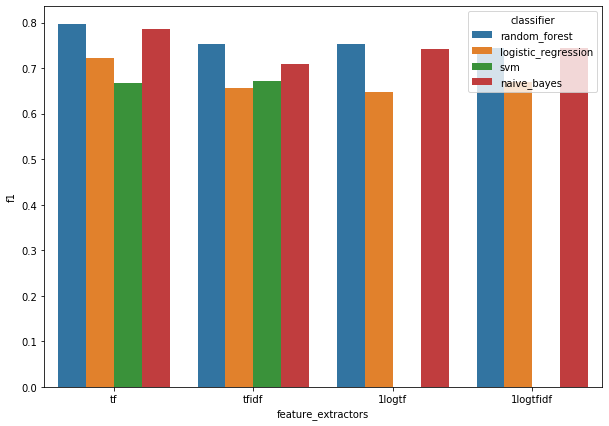

In [39]:
plt.figure(figsize=(10, 7))
df_cur = df[(df['nFeat'] == 500) & (df['feature_selectors'] == 'mi')]
sns.barplot('feature_extractors', 'f1', data=df_cur, hue='classifier')

accuracy

# Picking the best model

In [50]:
df.loc[df['f1'].idxmax()]

feature_extractors      1logtfidf
feature_selectors            chi2
nFeat                        1500
classifier            naive_bayes
acc                      0.885255
f1                       0.885644
precision                0.884687
recall                   0.887191
Name: 255, dtype: object

Test on Naive-Bayes

In [61]:
Bmodel = GridSearchCV(GaussianNB(), param_grid = {}, cv=5, verbose=2, scoring= ['accuracy','f1', 'precision', 'recall'], n_jobs = -1, refit = 'f1')

In [62]:
Bmodel.fit(x_test, y_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished
/home/maedeh97/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GaussianNB(priors=None, var_smoothing=1e-09), iid='warn',
             n_jobs=-1, param_grid={}, pre_dispatch='2*n_jobs', refit='f1',
             return_train_score=False,
             scoring=['accuracy', 'f1', 'precision', 'recall'], verbose=2)

In [71]:
test_accuracy = Bmodel.score(x_test, y_test)
print("test_accuracy: ", test_accuracy)

test_accuracy:  0.98989898989899


In [73]:
y_pred = Bmodel.predict(x_test)

In [75]:
test_f1 = sk.metrics.f1_score(y_test, y_pred)
print("test_f1: ", test_f1)

test_f1:  0.98989898989899


Multi-Class prediction First approach, classifying into 3 categories, negative, neutral, positive tweets

In [88]:
data_source_url = "https://raw.githubusercontent.com/kolaveridi/kaggle-Twitter-US-Airline-Sentiment-/master/Tweets.csv"
airline_tweets = pd.read_csv(data_source_url)

In [89]:
features = airline_tweets.iloc[:, 10].values
labels = airline_tweets.iloc[:, 1].values

In [94]:
processed_features = []

for sentence in range(0, len(features)):
    processed_feature = re.sub(r'\W', ' ', str(features[sentence]))
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) 
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)
    processed_feature = re.sub(r'^b\s+', '', processed_feature)
    processed_feature = processed_feature.lower()
    processed_features.append(processed_feature)

In [95]:
vectorizer = TfidfVectorizer (max_features=2500, min_df=7, max_df=0.8, stop_words=stopwords.words('english'))
processed_features = vectorizer.fit_transform(processed_features).toarray()

In [92]:
X_train, X_test, y_train, y_test = train_test_split(processed_features, labels, test_size=0.2, random_state=0)

In [93]:
mclassifier = RandomForestClassifier(n_estimators=200, random_state=0)
mclassifier.fit(X_train, y_train)

In [96]:
Test_features = newsd['meta_data-twitter-description'].iloc[:, 1].values

In [97]:
processed_Tfeatures = []

for sentence in range(0, len(features)):
    processed_Tfeatures = re.sub(r'\W', ' ', str(Test_features[sentence]))
    processed_Tfeatures= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_Tfeatures)
    processed_Tfeatures = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_Tfeatures) 
    processed_Tfeatures = re.sub(r'\s+', ' ', processed_Tfeatures, flags=re.I)
    processed_Tfeatures = re.sub(r'^b\s+', '', processed_Tfeatures)
    processed_Tfeatures = processed_Tfeatures.lower()
    processed_Tfeatures.append(processed_Tfeatures)

In [98]:
vectorizer = TfidfVectorizer (max_features=2500, min_df=7, max_df=0.8, stop_words=stopwords.words('english'))
processed_Tfeatures = vectorizer.fit_transform(processed_Tfeatures).toarray()

In [99]:
predictions = mclassifier.predict(processed_Tfeatures.toarray())

Multi-class second approach

In [76]:
probaYPred = Bmodel.predict_proba(x_test)

In [77]:
probaYPred

array([[1.00000000e+000, 0.00000000e+000],
       [1.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 1.00000000e+000],
       [0.00000000e+000, 1.00000000e+000],
       [1.00000000e+000, 0.00000000e+000],
       [1.00000000e+000, 0.00000000e+000],
       [1.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 1.00000000e+000],
       [1.00000000e+000, 0.00000000e+000],
       [1.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 1.00000000e+000],
       [1.00000000e+000, 0.00000000e+000],
       [1.00000000e+000, 0.00000000e+000],
       [1.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 1.00000000e+000],
       [1.00000000e+000, 0.00000000e+000],
       [1.00000000e+000, 0.00000000e+000],
       [1.00000000e+000, 0.00000000e+000],
       [1.00000000e+000, 0.00000000e+000],
       [1.00000000e+000, 0.00000000e+000],
       [1.00000000e+000, 0.00000000e+000],
       [1.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 1.00000000e+000],
       [1.0

In [85]:
probaYPred.shape

(200, 2)

In [100]:
from sklearn.metrics.pairwise import cosine_similarity
def get_cosine_sim(*strs): 
    vectors = [t for t in get_vectors(*strs)]
    return cosine_similarity(vectors)
    
def get_vectors(*strs):
    text = [t for t in strs]
    vectorizer = CountVectorizer(text)
    vectorizer.fit(text)
    return vectorizer.transform(text).toarray()

In [87]:
y = probaYPred[:,0] # if label is 0 then its a fake news if label is 1 then its a real news
y2 = np.copy(y)

y2[y < 0.3] = 0   #Real class
y2[(0.3 <= y) & (y< 0.5)] = 1 #Semi-Real class
y2[(0.5 <= y) & (y< 0.7)] = 2 #Semi-Fake class
y2[0.7 < y] = 3 #Fake class    

max f1 on Random Forest

In [69]:
df2 = df[df['classifier'] == 'random_forest']

In [70]:
df2.loc[df2['f1'].idxmax()]

feature_extractors               tf
feature_selectors              chi2
nFeat                          1500
classifier            random_forest
acc                        0.798226
f1                         0.802299
precision                  0.788658
recall                     0.816592
Name: 60, dtype: object

max f1 on Logistic Regression

In [78]:
df3 = df[df['classifier'] == 'logistic_regression']

In [80]:
df3.loc[df3['f1'].idxmax()]

feature_extractors                 1logtf
feature_selectors                    chi2
nFeat                                1500
classifier            logistic_regression
acc                              0.802106
f1                               0.796464
precision                        0.831185
recall                           0.764767
Name: 189, dtype: object

# Prediction on test data

In [101]:
Test_docs = []
entries = ('url', 'images', 'top_img','MobileOptimized','site', 'keywords', 'canonical_link',
           'movies', 'source', 'summary', 'publish_date')
md_entries = {'robots','HandheldFriendly', 'viewport', 'emailvertical','Generator', 'article',
              'msapplication-TileColor', 'msapplication-TileImage', 'msapplication-square70x70logo'
              , 'msapplication-square150x150logo', 'msapplication-square310x310logo',
              'msapplication-wide310x150logo','msvalidate.01', 'fb','apple-mobile-web-app-capable',
             'MobileOptimized'}
og_entries = {'type', 'url', 'image', 'MobileOptimized'}
tw_entries = {'card','url', 'image', 'MobileOptimized'}

for filename in glob('files/IR-FinalProject-DataSet/Real1/*.txt'):
    with open(filename) as file:
        data = file.read()
        # reconstructing the data as a dictionary
        f = json.loads(data)        
    
        
        for key in entries:
            if key in f:
                del f[key]
        for k in md_entries:
            if k in f['meta_data']:
                del f['meta_data'][k]
                
        for i, v in f.items():
            if i == 'og':
                for k in og_entries:
                    if k in f['og']:
                        del f['og'][k]
            if i == 'twitter':
                for k in tw_entries:
                    if k in f['twitter']:
                        del f['twitter'][k]
                                        
        for i in f['meta_data']:
            if i == 'og':
                for k in og_entries:
                    if k in f['meta_data']['og']:
                        del f['meta_data']['og'][k]
            if i == 'twitter':
                for k in tw_entries:
                    if k in f['meta_data']['twitter']:
                        del f['meta_data']['twitter'][k]
        
        f=flatten_dict(f)   
        Test_docs.append(f)

In [102]:
Test_newsd = pd.DataFrame(Test_docs)

In [103]:
Test_newsd.shape

(1003, 626)

In [104]:
Test_newsd

,text,authors,title,meta_data-title,meta_data-og-site_name,meta_data-og-title,meta_data-og-description,meta_data-twitter-title,meta_data-twitter-description,meta_data-twitter-site-identifier,...,meta_data-shorturl,meta_data-ContentItemType,meta_data-disqusidentifier,meta_data-reporting-call_config,meta_data-og-author,meta_data-asset_url,meta_data-expression,meta_data-facebook-domain-verification,meta_data-rj-id,meta_data-rj-paywall
0,,[],You are being redirected...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Kate Pearson's journey is only just beginning ...,[Philiana Ng],"Chrissy Metz Talks Kate's Challenging, But 'Re...","Chrissy Metz Talks Kate's Challenging, But 'Re...",Entertainment Tonight,Chrissy Metz on Kate's 'Relatable''This Is Us'...,The 38-year-old actress opens up to ET about e...,Chrissy Metz on Kate's 'Relatable''This Is Us'...,The 38-year-old actress opens up to ET about e...,@etnow,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,51 Romantic Movies to Watch Because There's Ho...,[],Celebrity Weddings and Engagements,NaN,Brides,Celebrity Weddings and Engagements,All the latest celebrity wedding news–from J.L...,Celebrity Weddings and Engagements,All the latest celebrity wedding news–from J.L...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Character on American television series Scanda...,[],Quinn Perkins,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"From there, you transition to the leg press ma...","[Karina Hoshikawa, Molly Longman, Emily Ruane,...",I Tried Kim Kardashian's Butt Workout & Am For...,"Kim Kardashian Butt Exercises, Workout Routine...",NaN,I Tried Kim Kardashian's Butt Workout & Am For...,Kim K. shared her exact butt workout on her ap...,I Tried Kim Kardashian's Butt Workout & Am For...,Kim K. shared her exact butt workout on her ap...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
998,Topher Grace Is a Dad! Actor and Wife Ashley H...,[Karen Mizoguchi],Topher Grace and Ashley Hinshaw Welcome Daught...,NaN,PEOPLE.com,Topher Grace and Ashley Hinshaw Welcome Daught...,Topher Grace and wife Ashley Hinshaw welcomed ...,Topher Grace and Ashley Hinshaw Welcome Daught...,Topher Grace and wife Ashley Hinshaw welcomed ...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
999,Khloe Kardashian being pregnant with her first...,"[Anna Lewis, News Editor, Anna Lewis Is The Ne...",Watch the exact moment Khloe Kardashian found ...,Khloe Kardashian found out she was pregnant on...,Cosmopolitan,Watch the exact moment Khloe Kardashian found ...,LOOK! There are two lines on the pregnancy test!,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000,George Clooney may find being a dad intimidati...,"[Kathleen Harper, Sabrina Rojas Weiss, Brenna ...",George Clooney Confesses Fatherhood Is ‘Terrif...,NaN,Hollywood Life,George Clooney Confesses Fatherhood Is ‘Terrif...,George Clooney may find being a dad intimidati...,George Clooney Confesses Fatherhood Is ‘Terrif...,George Clooney may find being a dad intimidati...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1001,Associated Press\n\nLOS ANGELES (AP) — Harvey ...,[],Harvey Weinstein's lawyers call Ashley Judd's ...,NaN,USA TODAY,Harvey Weinstein's lawyers call Ashley Judd's ...,Harvey Weinstein's lawyers have asked a judge ...,Harvey Weinstein's lawyers call Ashley Judd's ...,Harvey Weinstein's lawyers have asked a judge ...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [105]:
texts = Test_newsd['text'].tolist()
titles = Test_newsd['title'].tolist()
mdtitle = Test_newsd['meta_data-title'].tolist()
mdgtitle = Test_newsd['meta_data-og-title'].tolist()
mdgdescription = Test_newsd['meta_data-og-description'].tolist()
mdtwtitle = Test_newsd['meta_data-twitter-title'].tolist()
mdtwdescription = Test_newsd['meta_data-twitter-description'].tolist()
mdexpression = Test_newsd['meta_data-expression'].tolist()
mdkeywords = Test_newsd['meta_data-keywords'].tolist()
mdnewskeywords = Test_newsd['meta_data-news_keywords'].tolist()
mddescription = Test_newsd['meta_data-description'].tolist()

authors = Test_newsd['authors'].tolist()

In [106]:
for i in range(len(texts)):
    texts[i]=str(texts[i]) + str(titles[i]) + str(mdtitle[i]) +str(mdgtitle[i])+ str(mdgdescription[i])+ str(mdtwtitle[i])+ str(mdtwdescription[i])+ str(mdexpression[i])+ str(mdkeywords[i])+ str(mdnewskeywords[i])+str(mddescription[i]) 

In [107]:
texts = list(filter(None, texts))

In [108]:
Test_news = pd.DataFrame(texts, columns=['text'])
Test_news['label'] = ""

In [109]:
for k, v in Test_news.iterrows():
    #turning to lowercase
    v['text'] = v['text'].lower()
    # Remove unicode characters
    v['text'] = v['text'].encode('ascii', 'ignore').decode()
    stop_words = stopwords.words("english")
    v['text'] = ' '.join([word for word in v['text'].split(' ') if word not in stop_words])
    v['text'] = re.sub("https*\S+", " ", v['text'])
    v['text'] = re.sub("url", " ", v['text'])
    #Remove mentions
    v['text'] = re.sub("@\S+", " ", v['text'])
    # Remove Hashtags
    v['text'] = re.sub("#\S+", " ", v['text'])
    # Remove ticks and the next character
    v['text'] = re.sub("\'\w+", '', v['text'])
    # Remove punctuations
    v['text'] = re.sub('[%s]' % re.escape(string.punctuation), ' ', v['text'])
    # Remove numbers
    v['text'] = re.sub(r'\w*\d+\w*', '', v['text'])
    # Replace the over spaces
    v['text'] = re.sub('\s{2,}', " ", v['text'])

In [110]:
Test_news

,text,label
0,redirected nannannannannannannannannan,
1,kate pearson journey beginning us it roller co...,
2,romantic movies watch there hope how lose guy...,
3,character american television series scandal q...,
4,there transition leg press machine instead pla...,
...,...,...
998,topher grace dad actor wife ashley hinshaw wel...,
999,khloe kardashian pregnant first child easily o...,
1000,george clooney may find dad intimidating hes a...,
1001,associated press los angeles ap harvey weinste...,


# Feature extraction

In [145]:
#fit on train data
vectorizer = TfidfVectorizer(max_df=0.9, min_df=2, use_idf=True, stop_words=stopwords.words('english'), sublinear_tf=True)
Fnews_vec = vectorizer.fit(news['text'])
#transform on train data
Trnews_vec = Fnews_vec.transform(news['text'])
#transform on test data
Tnews_vec = Fnews_vec.transform(Test_news['text'])

# Feature selection

In [146]:
x_sel = SelectKBest(chi2, k = 1500).fit(Trnews_vec, news['label'])
x_sel = x_sel.transform(Tnews_vec)

In [147]:
bayes = GaussianNB()
search = GridSearchCV(forest, param_grid={}, cv=5, verbose=2, scoring= ['accuracy','f1', 'precision', 'recall'],n_jobs = -1, refit = 'f1')

In [148]:
x_selTr = SelectKBest(chi2, k = 1500).fit_transform(Trnews_vec, news['label'])

In [149]:
 x_train, x_test, y_train, y_test = sk.model_selection.train_test_split(x_selTr.toarray(), news['label'], test_size=200)

In [150]:
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [151]:
search.fit(x_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished
/home/maedeh97/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [152]:
search.predict(x_test)  # y_pred = search.predict(x_test)

array([1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 1])

In [153]:
search.score(x_test, y_test)

0.7655502392344498

In [ ]:
results = search.cv_results_

In [ ]:
results

In [154]:
y_pred = search.predict(x_sel)